# MAIN MASTER THESIS NOTEBOOK
### Mateusz Cedro

In [1]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import torch.nn.functional as F
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import copy
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
from IPython.display import clear_output
!pip install captum quantus

In [5]:
import pathlib
import random
import gc
import pandas as pd
import matplotlib
import seaborn as sns
import torch
import torchvision
from captum.attr import *
import quantus
import warnings
sns.set()

In [6]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
])

In [7]:
train_dir = r'/content/drive/covid_dataset/train_and_val/'
test_dir = r'/content/drive/covid_dataset/test/'

train_covid_dir = r'/content/drive/covid_dataset/train_and_val/covid/'
train_normal_dir = r'/content/drive/covid_dataset/train_and_val/normal/'

test_covid_dir = r'/content/drive/covid_dataset/test/covid/'
test_normal_dir = r'/content/drive/covid_dataset/test/normal/'

# Train-Val-Test Split

In [8]:
main_dataset = datasets.ImageFolder(train_dir, transforms_train)
train_dataset, val_dataset = torch.utils.data.random_split(main_dataset, [3058, 874], generator=torch.Generator().manual_seed(42))

test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [9]:
print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Train dataset size: 3058
Validation dataset size: 874
Test dataset size: 437
Class names: ['covid', 'normal']


In [10]:
print('Train dataset size:', type(train_dataset))
print('Validation dataset size:', type(val_dataset))
print('Test dataset size:', type(test_dataset))

Train dataset size: <class 'torch.utils.data.dataset.Subset'>
Validation dataset size: <class 'torch.utils.data.dataset.Subset'>
Test dataset size: <class 'torchvision.datasets.folder.ImageFolder'>


# Model

In [11]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=1, num_classes=2):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=1, num_classes=2):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=1, num_classes=2):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=1, num_classes=2):
    return ResNet(101, Block, img_channels, num_classes)

In [12]:
import gc
gc.collect()

0

# ResNet50

In [13]:
model = ResNet50()   # load resnet50 model

num_features = model.fc.in_features # extract fc layers features
model.fc = nn.Linear(num_features, 2) # (num_of_class == 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()  # Cross entropy with logits
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training

In [14]:
num_epochs = 50 
start_time = time.time()


# training stuff
training_loss = []
best_model_wts = copy.deepcopy(model.state_dict()) # saving best model
lowest_loss = 2.0

# validation stuff
validation_loss = []

for epoch in range(num_epochs): #(loop for every epoch)
    print("\nEpoch {} running".format(epoch)) #(printing message)

    """ Training Phase """
    model.train()
    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    training_loss.append(epoch_loss)

    print('[Train #{}] Loss: {:.3f}, Acc: {:.2f}%'.format(epoch, epoch_loss, epoch_acc))

    """ Validation Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        validation_loss.append(epoch_loss)

        if epoch_loss < lowest_loss:
            lowest_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print('[Validation #{}] Loss: {:.3f}, Acc: {:.2f}%'.format(epoch, epoch_loss, epoch_acc))
        print('Lowest val Cross Entropy Loss: {:3f}'.format(lowest_loss))
print('Time Taken for training: {:.2f} minutes'.format((time.time() - start_time)/60))


Epoch 0 running
[Train #0] Loss: 0.631, Acc: 68.51%
[Validation #0] Loss: 1.165, Acc: 65.90%
Lowest val Cross Entropy Loss: 1.164829

Epoch 1 running
[Train #1] Loss: 0.474, Acc: 78.19%
[Validation #1] Loss: 0.454, Acc: 82.38%
Lowest val Cross Entropy Loss: 0.454235

Epoch 2 running
[Train #2] Loss: 0.378, Acc: 83.71%
[Validation #2] Loss: 0.397, Acc: 80.32%
Lowest val Cross Entropy Loss: 0.397428

Epoch 3 running
[Train #3] Loss: 0.286, Acc: 87.97%
[Validation #3] Loss: 0.506, Acc: 83.64%
Lowest val Cross Entropy Loss: 0.397428

Epoch 4 running
[Train #4] Loss: 0.250, Acc: 89.63%
[Validation #4] Loss: 0.293, Acc: 86.96%
Lowest val Cross Entropy Loss: 0.293221

Epoch 5 running
[Train #5] Loss: 0.193, Acc: 92.25%
[Validation #5] Loss: 0.236, Acc: 91.53%
Lowest val Cross Entropy Loss: 0.236209

Epoch 6 running
[Train #6] Loss: 0.186, Acc: 93.23%
[Validation #6] Loss: 0.322, Acc: 87.07%
Lowest val Cross Entropy Loss: 0.236209

Epoch 7 running
[Train #7] Loss: 0.134, Acc: 94.96%
[Validati

In [15]:
torch.save(best_model_wts, r'/content/drive/covid_dataset/best_model_wts_colab_ResNet50_50epoch_A100')

# Load model trained on colab

In [16]:
# Load model GPU
model_path = r'/content/drive/covid_dataset/best_model_wts_colab_ResNet50_50epoch_A100'

model = ResNet50()
model.load_state_dict(torch.load(model_path))

model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

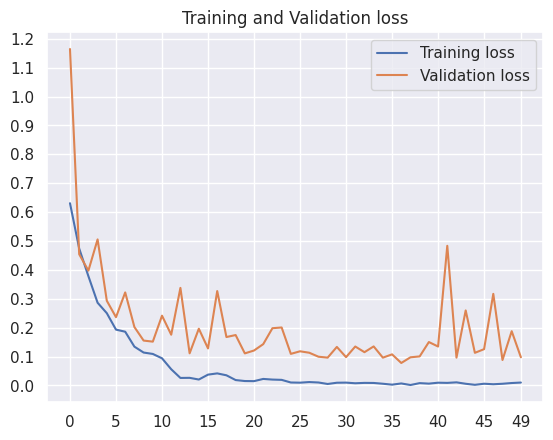

In [18]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(validation_loss, label = 'Validation loss')
plt.title('Training and Validation loss')

tick_locations = np.arange(0, num_epochs, step=5)
tick_locations = np.append(tick_locations, num_epochs - 1)
plt.xticks(tick_locations)
plt.yticks(np.arange(0, 1.3, step=0.1))
plt.legend()
plt.show()

## Test

In [19]:
##Testing

test_loss = []
labels_test = []
probabilities_list_test = []
preds_list_test = []

model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probabilities_test = F.softmax(outputs, dim=1)[:, 1]
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        labels_test.append(labels)
        probabilities_list_test.append(probabilities_test)
        preds_list_test.append(preds)

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    test_loss.append(epoch_loss)

    print('[Test] Loss: {:.3f}, Acc: {:.2f}%'.format(epoch_loss, epoch_acc))
print('Time Taken for testing: {:.2f} minutes'.format((time.time() - start_time)/60))

[Test] Loss: 0.168, Acc: 96.11%
Time Taken for testing: 0.67 minutes


## Metrics

In [20]:
# predicted clss - preds_list_test
labels_tensor = []

for tensor in labels_test:
    labels_tensor.append(tensor.tolist())

labels = [item for sublist in labels_tensor for item in sublist]

print("total labels: ", len(labels))

# predicted clss - preds_list_test
predicted_tensor = []

for tensor in preds_list_test:
    predicted_tensor.append(tensor.tolist())

predicted_class = [item for sublist in predicted_tensor for item in sublist]

print("total predicted_class: ", len(predicted_class))

# probabilities
proba_list_nottensors = []

for tensor in probabilities_list_test:
    proba_list_nottensors.append(tensor.tolist())

probs_of_class_1 = [item for sublist in proba_list_nottensors for item in sublist]
print("total probs_of_class_1: ", len(probs_of_class_1))

total labels:  437
total predicted_class:  437
total probs_of_class_1:  437


## ROC AUC

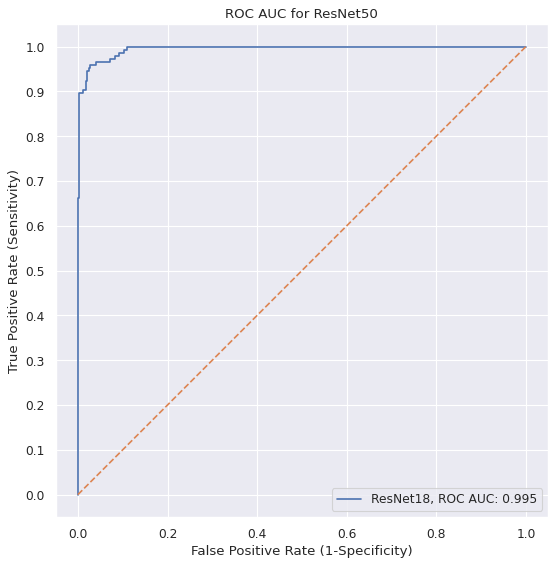

In [21]:
# ROC AUC
true_class = labels
nn_fpr, nn_tpr, nn_thresholds = roc_curve(true_class, probs_of_class_1)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(true_class))]
ns_auc = roc_auc_score(true_class, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(true_class, ns_probs)


# calculate AUC
roc_auc = roc_auc_score(true_class, probs_of_class_1)
#print('AUC: %.3f' % auc)
plt.figure(figsize=(8, 8), dpi=80)

plt.plot(nn_fpr, nn_tpr, #marker='.',
         label='ResNet18, ROC AUC: %.3f' % roc_auc)
plt.plot(ns_fpr, ns_fpr, linestyle='--') #label='')
plt.axis("square")
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.title('ROC AUC for ResNet50')
plt.legend(loc=4)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.show()

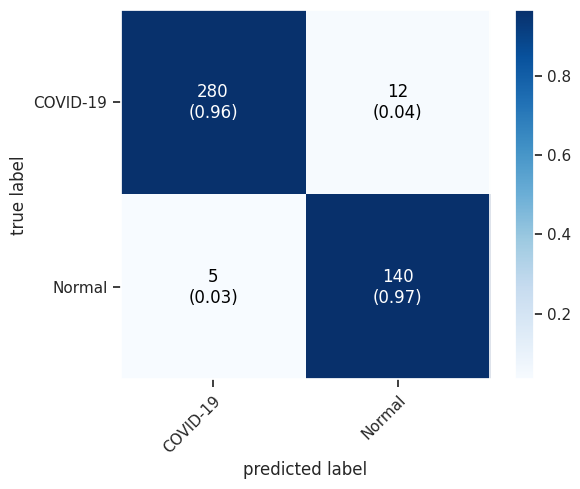

In [22]:
cm = confusion_matrix(true_class, predicted_class)

class_names = ['COVID-19', 'Normal']

fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                class_names=class_names)
plt.show()

In [23]:
print(classification_report(true_class, predicted_class))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       292
           1       0.92      0.97      0.94       145

    accuracy                           0.96       437
   macro avg       0.95      0.96      0.96       437
weighted avg       0.96      0.96      0.96       437



## Check of random pictuers from test set from both classes

In [24]:
def pre_image(image_path, model):
    path=os.path.dirname(image_path) # path for classes
    img = Image.open(image_path)
    x = transforms_test(img)  # Preprocess image
    inputs = x.unsqueeze(0)  # Add batch dimension
    inputs = inputs.to(device)
    labels = os.path.basename(path)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    probs = torch.sigmoid(_)
    print("True class:", '\033[1m' , labels.upper(), '\033[0m', 'where 0=covid, 1=normal')
    print(' ')
    print('Predicted class:', preds.cpu().detach().numpy(), f"with {probs.cpu().detach().numpy()} probability")

In [25]:
normal_test_path = r'/content/drive/covid_dataset/test/normal/Normal (150).png'

pre_image(normal_test_path, model)

True class:  NORMAL  where 0=covid, 1=normal
 
Predicted class: [1] with [0.98921084] probability


In [26]:
covid_test_path = r'/content/drive/covid_dataset/test/covid/covid_2797.png'

pre_image(covid_test_path, model)

True class:  COVID  where 0=covid, 1=normal
 
Predicted class: [0] with [0.999469] probability


# XAI

In [27]:
from IPython.display import clear_output
!pip install torch torchvision captum xmltodict quantus
clear_output()

In [32]:
test_dataset = datasets.ImageFolder(test_dir, transforms_test)
exp_set_img, _ = torch.utils.data.random_split(test_dataset, [18, 419], generator=torch.Generator().manual_seed(42))
exp_set_dataloader = torch.utils.data.DataLoader(exp_set_img, batch_size=18, shuffle=False)

test_masks_path = r'/content/drive/covid_dataset/test_masks/'

test_dataset_masks = datasets.ImageFolder(test_masks_path, transforms_test)
exp_set_mask, _ = torch.utils.data.random_split(test_dataset_masks, [18, 419], generator=torch.Generator().manual_seed(42))
test_masks_dataloader = torch.utils.data.DataLoader(exp_set_mask, batch_size=18, shuffle=False)


for i, (inputs, labels) in enumerate(exp_set_dataloader):
        x_batch = inputs.to(device)
        y_batch = labels.to(device)

for i_masks, (inputs_masks, labels_masks) in enumerate(test_masks_dataloader):
        s_batch = inputs_masks.to(device)

In [33]:
s_batch = torch.where(s_batch < 0.0, 0.0, 1.0)

In [34]:
print(f" x_batch {len(x_batch)} matches found.")
print(f" y_batch {len(y_batch)} matches found.")
print(f" s_batch {len(s_batch)} matches found.")

 x_batch 18 matches found.
 y_batch 18 matches found.
 s_batch 18 matches found.


In [35]:
print('y_batch :', np.unique(y_batch.cpu(), return_counts=True))

y_batch : (array([0, 1]), array([10,  8]))


In [36]:
print('s_batch :', np.unique(s_batch.cpu(), return_counts=False))

s_batch : [0. 1.]


In [37]:
class_names = test_dataset.classes
print('Class names:', class_names)
print(" ")
class_mask_names = test_dataset_masks.classes
print('Class names:', class_mask_names)

Class names: ['covid', 'normal']
 
Class names: ['covid_infection_mask', 'normal_infection_mask_lungs']


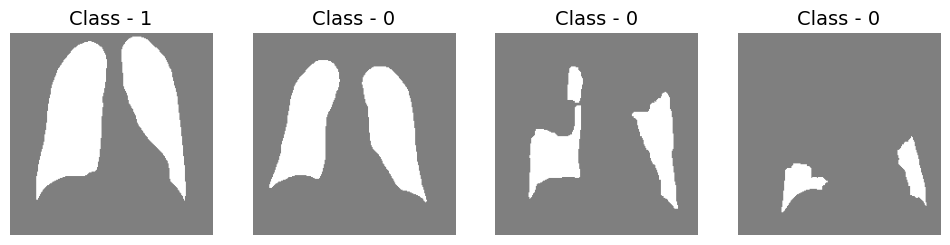

In [38]:
nr_images = [0,1,2,3]
fig, axes = plt.subplots(nrows=1, ncols=len(nr_images), figsize=(len(nr_images)*3, int(len(nr_images)*3)))
for i in nr_images:
    axes[nr_images.index(i)].imshow((np.moveaxis(quantus.normalise_func.denormalise(s_batch[i].cpu().numpy(),
                                                                                    mean=np.array([0.5, 0.5, 0.5]),
                                                                                    std=np.array([0.5, 0.5, 0.5])),
                                                 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap='gray')
    axes[nr_images.index(i)].set_title(f"Class - {y_batch[i].item()}", fontsize=14, color='black')
    axes[nr_images.index(i)].axis("off")
plt.show()

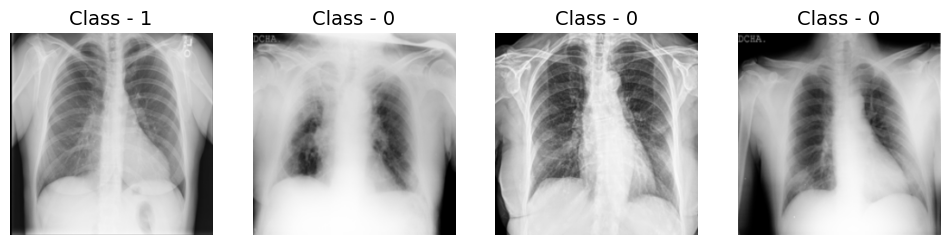

In [39]:
# X-RAYS
nr_images = [0,1,2,3]
fig, axes = plt.subplots(nrows=1, ncols=len(nr_images), figsize=(len(nr_images)*3, int(len(nr_images)*3)))
for i in nr_images:
    axes[nr_images.index(i)].imshow((np.moveaxis(quantus.normalise_func.denormalise(x_batch[i].cpu().numpy(),
                                                                                    mean=np.array([0.5, 0.5, 0.5]),
                                                                                    std=np.array([0.5, 0.5, 0.5])),
                                                 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[nr_images.index(i)].set_title(f"Class - {y_batch[i].item()}", fontsize=14, color='black')
    axes[nr_images.index(i)].axis("off")
plt.show()

In [40]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, _, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])

    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())

In [41]:
### NOTE: I have changed input channels to 1 (insteead of 3)

def explainer_wrapper(**kwargs):
    """Wrapper for explainer functions."""
    if kwargs["method"] == "Saliency":
        return saliency_explainer(**kwargs)
    elif kwargs["method"] == "IntegratedGradients":
        return intgrad_explainer(**kwargs)
    elif kwargs["method"] == "GradientShap":
        return gradshap_explainer(**kwargs)
    else:
        raise ValueError("Pick an explaination function that exists.")


def saliency_explainer(
    model, inputs, targets, abs=False, normalise=False, *args, **kwargs
) -> np.array:
    """Wrapper around captum's Saliency implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 1),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
            .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = (
            torch.as_tensor(targets).long().to(kwargs.get("device", None))
        )  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        Saliency(model)
        .attribute(inputs, targets, abs=abs)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def intgrad_explainer(
    model, inputs, targets, abs=False, normalise=False, *args, **kwargs
) -> np.array:
    """Wrapper aorund captum's Integrated Gradients implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 1),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
            .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        IntegratedGradients(model)
        .attribute(
            inputs=inputs,
            target=targets,
            baselines=torch.zeros_like(inputs),
            n_steps=25, # defalut n=50, recomended range = [20, 300]
            method="riemann_trapezoid",
        )
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def gradshap_explainer(
    model, inputs, targets, abs=False, normalise=False, *args, **kwargs
) -> np.array:
    """Wrapper aorund captum's GradShap implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 1),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
            .to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    baselines = torch.zeros_like(inputs).to(kwargs.get("device", None))
    explanation = (
        GradientShap(model)
        .attribute(inputs=inputs, target=targets, baselines=baselines)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [42]:
gc.collect()

15271

In [43]:
torch.cuda.empty_cache()

In [44]:
# Produce explanations and empty cache to to survive memory-wise.
torch.manual_seed(42)
np.random.seed(42)

print('Saliency:')
# Saliency.
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = saliency_explainer(model=model,
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )

print('GradShap:')
# GradShap.
gc.collect()
torch.cuda.empty_cache()
a_batch_gradshap = gradshap_explainer(model=model,
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )

print('IntGrad:')
#Integrated Gradients.
gc.collect()
torch.cuda.empty_cache()
a_batch_intgrad = intgrad_explainer(model=model,
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )

# Save explanations to file.
explanations = {
    "Saliency": a_batch_saliency,
    "GradientShap": a_batch_gradshap,
    "IntegratedGradients": a_batch_intgrad,
}

Saliency:


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


GradShap:
IntGrad:


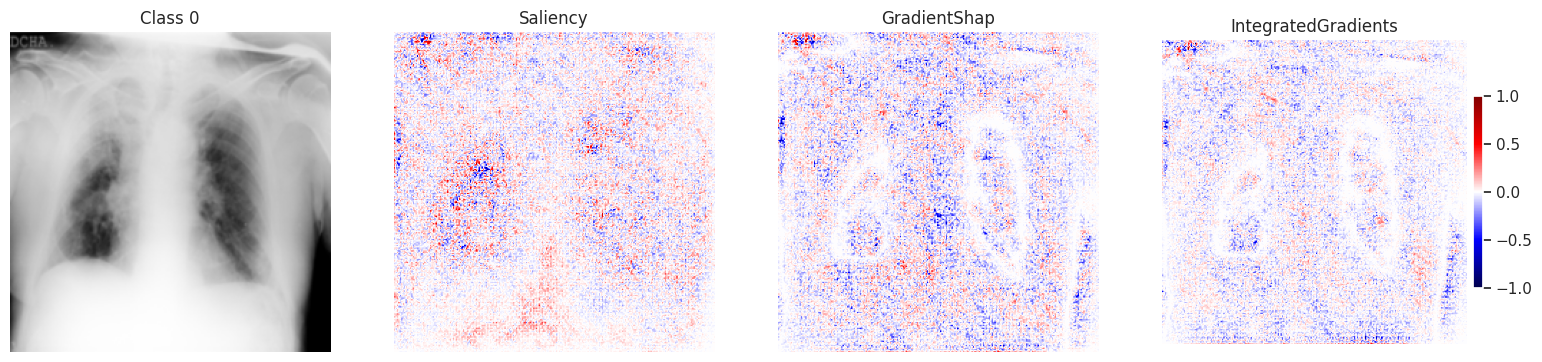

In [47]:
index = 1
fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(19, 10))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[index].cpu().detach().numpy(),
                                                              mean=np.array([0.5, 0.5, 0.5]),
                                                              std=np.array([0.5, 0.5, 0.5])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Class {y_batch[index].item()}")
axes[0].axis("off");
for i, (k, v) in enumerate(explanations.items()):
    axes[i+1].imshow(quantus.normalise_func.normalise_by_negative(explanations[k][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[i+1].title.set_text(f"{k}")
    axes[i+1].axis("off")

exp = axes[3].imshow(quantus.normalise_func.normalise_by_negative(explanations[k][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
fig.colorbar(exp, fraction=0.03, pad=0.02);

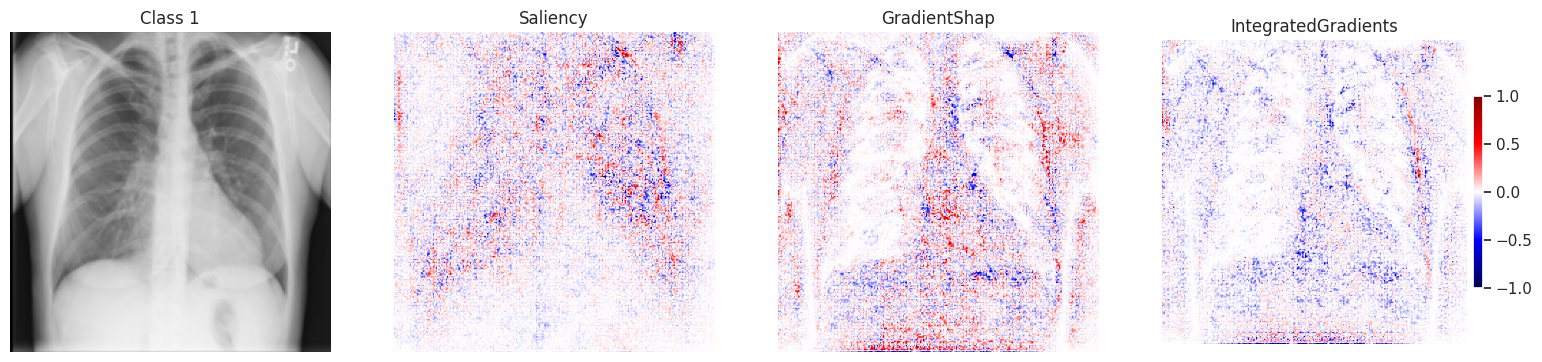

In [48]:
index = 0 #random.randint(0, len(x_batch)-1)
fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(19, 10))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[index].cpu().numpy(), mean=np.array([0.5, 0.5, 0.5]), std=np.array([0.5, 0.5, 0.5])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Class {y_batch[index].item()}")
axes[0].axis("off");
for i, (k, v) in enumerate(explanations.items()):
    axes[i+1].imshow(quantus.normalise_func.normalise_by_negative(explanations[k][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[i+1].title.set_text(f"{k}")
    axes[i+1].axis("off")

exp = axes[3].imshow(quantus.normalise_func.normalise_by_negative(explanations[k][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
fig.colorbar(exp, fraction=0.03, pad=0.02);

## 2.2 Quantiative analysis

In the following sections, we quantify the explanations through different properties and conduct sensitivity analysis.

In [ ]:
"""This module contains the implementation of the Relevance Mass Accuracy metric."""

# This file is part of Quantus.
# Quantus is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# Quantus is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.
# You should have received a copy of the GNU Lesser General Public License along with Quantus. If not, see <https://www.gnu.org/licenses/>.
# Quantus project URL: <https://github.com/understandable-machine-intelligence-lab/Quantus>.

from typing import Any, Callable, Dict, List, Optional, Tuple
import numpy as np
from IPython.display import display
from PIL import Image

from quantus.helpers import asserts
from quantus.helpers import warn
from quantus.helpers.model.model_interface import ModelInterface
from quantus.functions.normalise_func import normalise_by_max
from quantus.metrics.base import Metric
from quantus.helpers.enums import (
    ModelType,
    DataType,
    ScoreDirection,
    EvaluationCategory,
)


class RelevanceMassAccuracy(Metric):
    """
    Implementation of the Relevance Mass Accuracy by Arras et al., 2021.

    The Relevance Mass Accuracy computes the ratio of attributions inside the bounding box to
    the sum of overall positive attributions. High scores are desired, as the pixels with the highest positively
    attributed scores should be within the bounding box of the targeted object.

    References:
        1) Leila Arras et al.: "CLEVR-XAI: A benchmark dataset for the ground
        truth evaluation of neural network explanations." Inf. Fusion 81 (2022): 14-40.

    Attributes:
        -  _name: The name of the metric.
        - _data_applicability: The data types that the metric implementation currently supports.
        - _models: The model types that this metric can work with.
        - score_direction: How to interpret the scores, whether higher/ lower values are considered better.
        - evaluation_category: What property/ explanation quality that this metric measures.
    """

    name = "Relevance Mass Accuracy"
    data_applicability = {DataType.IMAGE, DataType.TIMESERIES, DataType.TABULAR}
    model_applicability = {ModelType.TORCH, ModelType.TF}
    score_direction = ScoreDirection.HIGHER
    evaluation_category = EvaluationCategory.LOCALISATION

    def __init__(
        self,
        abs: bool = False,
        normalise: bool = True,
        normalise_func: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        normalise_func_kwargs: Optional[Dict[str, Any]] = None,
        return_aggregate: bool = False,
        aggregate_func: Callable = np.mean,
        default_plot_func: Optional[Callable] = None,
        disable_warnings: bool = False,
        display_progressbar: bool = False,
        **kwargs,
    ):
        """
        Parameters
        ----------
        abs: boolean
            Indicates whether absolute operation is applied on the attribution, default=False.
        normalise: boolean
            Indicates whether normalise operation is applied on the attribution, default=True.
        normalise_func: callable
            Attribution normalisation function applied in case normalise=True.
            If normalise_func=None, the default value is used, default=normalise_by_max.
        normalise_func_kwargs: dict
            Keyword arguments to be passed to normalise_func on call, default={}.
        return_aggregate: boolean
            Indicates if an aggregated score should be computed over all instances.
        aggregate_func: callable
            Callable that aggregates the scores given an evaluation call.
        default_plot_func: callable
            Callable that plots the metrics result.
        disable_warnings: boolean
            Indicates whether the warnings are printed, default=False.
        display_progressbar: boolean
            Indicates whether a tqdm-progress-bar is printed, default=False.
        kwargs: optional
            Keyword arguments.
        """
        if normalise_func is None:
            normalise_func = normalise_by_max

        super().__init__(
            abs=abs,
            normalise=normalise,
            normalise_func=normalise_func,
            normalise_func_kwargs=normalise_func_kwargs,
            return_aggregate=return_aggregate,
            aggregate_func=aggregate_func,
            default_plot_func=default_plot_func,
            display_progressbar=display_progressbar,
            disable_warnings=disable_warnings,
            **kwargs,
        )

        # Asserts and warnings.
        if not self.disable_warnings:
            warn.warn_parameterisation(
                metric_name=self.__class__.__name__,
                sensitive_params=(
                    "ground truth mask i.e., the 's_batch' as well as if the attributions"
                    " are normalised 'normalise' (and 'normalise_func') and/ or taking "
                    "absolute values of such 'abs'"
                ),
                citation=(
                    "Arras, Leila, Osman, Ahmed, and Samek, Wojciech. 'Ground Truth Evaluation "
                    "of Neural Network Explanations with CLEVR-XAI.' arXiv preprint, "
                    "arXiv:2003.07258v2 (2021)."
                ),
            )

    def __call__(
        self,
        model,
        x_batch: np.array,
        y_batch: np.array,
        a_batch: Optional[np.ndarray] = None,
        s_batch: Optional[np.ndarray] = None,
        channel_first: Optional[bool] = None,
        explain_func: Optional[Callable] = None,
        explain_func_kwargs: Optional[Dict] = None,
        model_predict_kwargs: Optional[Dict] = None,
        softmax: Optional[bool] = False,
        device: Optional[str] = None,
        batch_size: int = 64,
        custom_batch: Optional[Any] = None,
        **kwargs,
    ) -> List[float]:
        """
        This implementation represents the main logic of the metric and makes the class object callable.
        It completes instance-wise evaluation of explanations (a_batch) with respect to input data (x_batch),
        output labels (y_batch) and a torch or tensorflow model (model).

        Calls general_preprocess() with all relevant arguments, calls
        () on each instance, and saves results to evaluation_scores.
        Calls custom_postprocess() afterwards. Finally returns evaluation_scores.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        channel_first: boolean, optional
            Indicates of the image dimensions are channel first, or channel last.
            Inferred from the input shape if None.
        explain_func: callable
            Callable generating attributions.
        explain_func_kwargs: dict, optional
            Keyword arguments to be passed to explain_func on call.
        model_predict_kwargs: dict, optional
            Keyword arguments to be passed to the model's predict method.
        softmax: boolean
            Indicates whether to use softmax probabilities or logits in model prediction.
            This is used for this __call__ only and won't be saved as attribute. If None, self.softmax is used.
        device: string
            Indicated the device on which a torch.Tensor is or will be allocated: "cpu" or "gpu".
        kwargs: optional
            Keyword arguments.

        Returns
        -------
        evaluation_scores: list
            a list of Any with the evaluation scores of the concerned batch.

        Examples:
        --------
            # Minimal imports.
            >> import quantus
            >> from quantus import LeNet
            >> import torch

            # Enable GPU.
            >> device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # Load a pre-trained LeNet classification model (architecture at quantus/helpers/models).
            >> model = LeNet()
            >> model.load_state_dict(torch.load("tutorials/assets/pytests/mnist_model"))

            # Load MNIST datasets and make loaders.
            >> test_set = torchvision.datasets.MNIST(root='./sample_data', download=True)
            >> test_loader = torch.utils.data.DataLoader(test_set, batch_size=24)

            # Load a batch of inputs and outputs to use for XAI evaluation.
            >> x_batch, y_batch = iter(test_loader).next()
            >> x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

            # Generate Saliency attributions of the test set batch of the test set.
            >> a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1)
            >> a_batch_saliency = a_batch_saliency.cpu().numpy()

            # Initialise the metric and evaluate explanations by calling the metric instance.
            >> metric = Metric(abs=True, normalise=False)
            >> scores = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch_saliency}
        """
        return super().__call__(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
            custom_batch=None,
            channel_first=channel_first,
            explain_func=explain_func,
            explain_func_kwargs=explain_func_kwargs,
            softmax=softmax,
            device=device,
            model_predict_kwargs=model_predict_kwargs,
            **kwargs,
        )

    def evaluate_instance(
        self,
        model: ModelInterface,
        x: np.ndarray,
        y: np.ndarray,
        a: np.ndarray,
        s: np.ndarray,
    ) -> float:
        """
        Evaluate instance gets model and data for a single instance as input and returns the evaluation result.

        Parameters
        ----------
        model: ModelInterface
            A ModelInteface that is subject to explanation.
        x: np.ndarray
            The input to be evaluated on an instance-basis.
        y: np.ndarray
            The output to be evaluated on an instance-basis.
        a: np.ndarray
            The explanation to be evaluated on an instance-basis.
        s: np.ndarray
            The segmentation to be evaluated on an instance-basis.

        Returns
        -------
        float
            The evaluation results.
        """
        # Return np.nan as result if segmentation map is empty.
        if np.sum(s) == 0:
            warn.warn_empty_segmentation()
            return np.nan

        # Prepare shapes.
        a = a.flatten()
        s = s.flatten().astype(bool)

        # Compute inside/outside ratio.
        r_within = np.sum(a[(a > 0) & (s > 0)]) # I have changed that from the original Quantus implementation
        r_total = np.sum(a[a>0])

        # Calculate mass accuracy.
        mass_accuracy = r_within / r_total

        return mass_accuracy

    def custom_preprocess(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: Optional[np.ndarray],
        a_batch: Optional[np.ndarray],
        s_batch: np.ndarray,
        custom_batch: Optional[np.ndarray],
    ) -> None:
        """
        Implementation of custom_preprocess_batch.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model e.g., torchvision.models that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        custom_batch: any
            Gives flexibility ot the user to use for evaluation, can hold any variable.

        Returns
        -------
        None
        """
        # Asserts.
        asserts.assert_segmentations(x_batch=x_batch, s_batch=s_batch)

In [55]:
# Define XAI methods and metrics.
xai_methods = list(explanations.keys())
metrics = {
    "Relevance Rank Accuracy": quantus.RelevanceRankAccuracy(
        abs=False,
        normalise=True,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Relevance Mass Accuracy": RelevanceMassAccuracy(
        abs=False,
        normalise=True,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
}

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
# Empty cache.
gc.collect()
torch.cuda.empty_cache()

In [58]:
torch.manual_seed(42)
np.random.seed(42)

results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():

        print(f"Evaluating {metric} of {method} method.")
        gc.collect()
        torch.cuda.empty_cache()

        # Get scores and append results.
        scores = metric_func(
            model=model.to(device),
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=None,
            s_batch=s_batch.reshape(len(x_batch), 1, 224, 224).cpu().numpy(),
            device=device,
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
                "device": device,
            },
        )
        print(scores)
        print(" ")
        results[method][metric] = scores

        # Empty cache.
        gc.collect()
        torch.cuda.empty_cache()

Evaluating Relevance Rank Accuracy of Saliency method.
[0.24634498299382157]
 
Evaluating Relevance Mass Accuracy of Saliency method.
[-0.051330645]
 
Evaluating Relevance Rank Accuracy of GradientShap method.
[0.165936026773295]
 
Evaluating Relevance Mass Accuracy of GradientShap method.
[0.5535475]
 
Evaluating Relevance Rank Accuracy of IntegratedGradients method.
[0.171927477527443]
 
Evaluating Relevance Mass Accuracy of IntegratedGradients method.
[-0.15076657]
 


In [60]:
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()
df

,Relevance Rank Accuracy,Relevance Mass Accuracy
Saliency,0.246345,0.051331
GradientShap,0.165936,0.553548
IntegratedGradients,0.171927,0.150767
